In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Метки с образованием

In [2]:
train_labels = pd.read_csv('course/vtb/education/train.csv')

### Клисктрим и транзации

In [3]:
transactions = pd.read_csv('course/vtb/transactions.csv')
clickstream = pd.read_csv('course/vtb/clickstream.csv')
train_matching = pd.read_csv('course/vtb/train_matching.csv')

In [4]:
transactions.transaction_dttm=pd.to_datetime(transactions.transaction_dttm)
transactions['hour']=transactions.transaction_dttm.dt.hour
transactions['dow']=transactions.transaction_dttm.dt.dayofweek
transactions['month']=transactions.transaction_dttm.dt.month
transactions['date']=transactions.transaction_dttm.dt.date
transactions['hour_minute']=transactions.transaction_dttm.dt.strftime('%H:%M')

In [5]:
def is_not_rub(row):
    if row.currency_rk in [50,60]:
        return(1)
    else:
        return(0)
transactions['not_rub']=transactions.apply(lambda row: is_not_rub(row),axis=1)
foreign_currency=transactions[['user_id','not_rub']]
foreign_currency=foreign_currency.drop_duplicates()
foreign_currency.index=foreign_currency['user_id']
foreign_currency=foreign_currency.drop('user_id', axis=1)

agg_func={'not_rub':['max']}
foreign_currency=foreign_currency.groupby('user_id').agg(agg_func)
foreign_currency.columns=['not_rub']

In [6]:
agg_func={'hour_minute':['nunique']}
transactions_minutes=transactions.groupby(['user_id','date','dow']).agg(agg_func)
transactions_minutes.columns=['nunique']
transactions_minutes=pd.pivot_table(transactions_minutes,index='user_id',columns='dow',values='nunique',aggfunc='mean').fillna(0)
transactions_minutes.columns=['avg_uniq_minutes_per_day_'+str(i)+'_tr'  for i in transactions_minutes.columns]

In [7]:
agg_func={'transaction_amt':['sum','mean','max','min']}

transactions_agg=transactions.groupby(['user_id','month']).agg(agg_func)
transactions_agg=transactions_agg.groupby(['user_id']).agg('mean')
transactions_agg.columns=['_'.join(col).strip()+'_by_month' for col in transactions_agg.columns.values]

In [8]:
transactions['date_shift']=transactions.groupby(['user_id','mcc_code'])['date'].shift(1)
transactions[['date','date_shift']] = transactions[['date','date_shift']].apply(pd.to_datetime) #if conversion required
transactions['date_diff'] = (transactions['date'] - transactions['date_shift']).dt.days

transactions_calc=transactions[['user_id','mcc_code','date','date_shift','date_diff']]
transactions_calc=transactions_calc.drop_duplicates()
transactions_calc=transactions_calc.dropna()

transactions_calc=pd.pivot_table(transactions_calc,index='user_id',columns='mcc_code',values='date_diff',aggfunc='mean').fillna(0)
transactions_calc.columns=[str(i)+'_avg_date_diff'+'_tr'  for i in transactions_calc.columns]

In [9]:
tr_dow=pd.pivot_table(transactions,index='user_id',columns='dow',values='transaction_amt',aggfunc='count').fillna(0)
tr_dow['summ']=tr_dow.sum(axis=1)
for i in tr_dow.columns[:-1]:
    tr_dow[i]/=tr_dow['summ']
tr_dow.columns=['prc_dow_tr_'+str(i) for i in tr_dow.columns]
tr_dow=tr_dow.rename(columns={'prc_dow_tr_summ':'summ'})
tr_dow=tr_dow.drop(['summ'],axis=1)

In [10]:
tr_h=pd.pivot_table(transactions,index='user_id',columns='hour',values='transaction_amt',aggfunc='count').fillna(0)
tr_h['summ']=tr_h.sum(axis=1)
for i in tr_h.columns[:-1]:
    tr_h[i]/=tr_h['summ']
tr_h.columns=['prc_h_tr_'+str(i) for i in tr_h.columns]
tr_h=tr_h.rename(columns={'prc_h_tr_summ':'summ'})
tr_h=tr_h.drop(['summ'],axis=1)

In [11]:
tr_ctg=pd.pivot_table(transactions,index='user_id',columns='mcc_code',values='transaction_amt',aggfunc='sum').fillna(0)
tr_ctg['summ']=tr_ctg.sum(axis=1)
for i in tr_ctg.columns[:-1]:
    tr_ctg[i]/=tr_ctg['summ']
tr_ctg.columns=['prc_ctg_sum_tr_'+str(i) for i in tr_ctg.columns]
tr_ctg=tr_ctg.rename(columns={'prc_ctg_sum_tr_summ':'summ'})
tr_ctg=tr_ctg.drop(['summ'],axis=1)

In [12]:
clickstream.timestamp=pd.to_datetime(clickstream.timestamp)
clickstream['hour']=clickstream.timestamp.dt.hour
clickstream['dow']=clickstream.timestamp.dt.dayofweek
clickstream['date']=clickstream.timestamp.dt.date
clickstream['hour_minute']=clickstream.timestamp.dt.strftime('%H:%M')

In [13]:
clickstream['date_shift']=clickstream.groupby(['user_id','cat_id'])['date'].shift(1)
clickstream[['date','date_shift']] = clickstream[['date','date_shift']].apply(pd.to_datetime) #if conversion required
clickstream['date_diff'] = (clickstream['date'] - clickstream['date_shift']).dt.days

clickstream_calc=clickstream[['user_id','cat_id','date','date_shift','date_diff']]
clickstream_calc=clickstream_calc.drop_duplicates()
clickstream_calc=clickstream_calc.dropna()

clickstream_calc=pd.pivot_table(clickstream_calc,index='user_id',columns='cat_id',values='date_diff',aggfunc='mean').fillna(0)
clickstream_calc.columns=[str(i)+'_avg_date_diff'+'_cl'  for i in clickstream_calc.columns]

In [14]:
agg_func={'hour_minute':['nunique']}
clickstream_minutes=clickstream.groupby(['user_id','date','dow']).agg(agg_func)
clickstream_minutes.columns=['nunique']
clickstream_minutes=pd.pivot_table(clickstream_minutes,index='user_id',columns='dow',values='nunique',aggfunc='mean').fillna(0)
clickstream_minutes.columns=['avg_uniq_minutes_per_day_'+str(i)+'_cl'  for i in clickstream_minutes.columns]

In [15]:
agg_func={'new_uid':['nunique']}
clickstream_unq_device=clickstream.groupby(['user_id']).agg(agg_func)
clickstream_unq_device.columns=['cnt_unq_device_cl']

In [16]:
cl_dow=pd.pivot_table(clickstream,index='user_id',columns='dow',values='timestamp',aggfunc='count').fillna(0)
cl_dow['summ']=cl_dow.sum(axis=1)
for i in cl_dow.columns[:-1]:
    cl_dow[i]/=cl_dow['summ']
cl_dow.columns=['prc_dow_cl_'+str(i) for i in cl_dow.columns]
cl_dow=cl_dow.rename(columns={'prc_dow_cl_summ':'summ'})
cl_dow=cl_dow.drop(['summ'],axis=1)

In [17]:
cl_h=pd.pivot_table(clickstream,index='user_id',columns='hour',values='timestamp',aggfunc='count').fillna(0)
cl_h['summ']=cl_h.sum(axis=1)
for i in cl_h.columns[:-1]:
    cl_h[i]/=cl_h['summ']
cl_h.columns=['prc_h_cl_'+str(i) for i in cl_h.columns]
cl_h=cl_h.rename(columns={'prc_h_cl_summ':'summ'})
cl_h=cl_h.drop(['summ'],axis=1)

In [18]:
cl_ctg=pd.pivot_table(clickstream,index='user_id',columns='cat_id',values='timestamp',aggfunc='count').fillna(0)
cl_ctg['summ']=cl_ctg.sum(axis=1)
for i in cl_ctg.columns[:-1]:
    cl_ctg[i]/=cl_ctg['summ']
cl_ctg.columns=['prc_ctg_cnt_cl_'+str(i) for i in cl_ctg.columns]
cl_ctg=cl_ctg.rename(columns={'prc_ctg_cnt_cl_summ':'summ'})
cl_ctg=cl_ctg.drop(['summ'],axis=1)

### Из решения

In [19]:
bankclient_embed = transactions.pivot_table(index = 'user_id', 
                         values=['transaction_amt'],
                         columns=['mcc_code'],
                         aggfunc=['sum','mean', 'count']).fillna(0)

bankclient_embed.columns = ['tr-'+f'{str(i[0])}-{str(i[2])}' for i in bankclient_embed.columns]

In [20]:
clickstream_embed = clickstream.pivot_table(index = 'user_id', 
                         values=['timestamp'],
                         columns=['cat_id'],
                         aggfunc=['count']).fillna(0)

clickstream_embed.columns = ['cl-'+f'{str(i[0])}-{str(i[2])}' for i in clickstream_embed.columns]

### Новый способ

In [22]:
tr_vectors_df=pd.read_csv('course/vtb/tr_vectors_dv.csv')
cl_vectors_df=pd.read_csv('course/vtb/cl_vectors_dv.csv')

tr_vectors_df.set_index('user_id', inplace=True)
cl_vectors_df.set_index('user_id', inplace=True)

In [21]:
full_dataset = train_labels.merge(train_matching,how='left',on='bank')\
               .merge(bankclient_embed, how='left', left_on='bank', right_index=True)\
               .merge(clickstream_embed, how='left', left_on='rtk', right_index=True)\
               .merge(tr_dow, how='left', left_on='bank', right_index=True)\
               .merge(tr_h, how='left', left_on='bank', right_index=True)\
               .merge(transactions_agg, how='left', left_on='bank', right_index=True)\
               .merge(transactions_minutes, how='left', left_on='bank', right_index=True)\
               .merge(transactions_calc, how='left', left_on='bank', right_index=True)\
               .merge(foreign_currency, how='left', left_on='bank', right_index=True)\
               .merge(cl_dow, how='left', left_on='rtk', right_index=True)\
               .merge(cl_h, how='left', left_on='rtk', right_index=True)\
               .merge(clickstream_minutes, how='left', left_on='rtk', right_index=True)\
               .merge(clickstream_calc, how='left', left_on='bank', right_index=True)\
               .merge(clickstream_unq_device, how='left', left_on='rtk', right_index=True)\
               .merge(tr_ctg, how='left', left_on='bank', right_index=True)\
               .merge(cl_ctg, how='left', left_on='rtk', right_index=True)\
               .fillna(0)

full_dataset=full_dataset.rename(columns={'higher_education':'target'})

In [22]:
full_dataset[:3]

,bank,target,rtk,tr-sum--1,tr-sum-742,tr-sum-763,tr-sum-780,tr-sum-1520,tr-sum-1711,tr-sum-1731,...,prc_ctg_cnt_cl_1819,prc_ctg_cnt_cl_1840,prc_ctg_cnt_cl_1848,prc_ctg_cnt_cl_1849,prc_ctg_cnt_cl_1850,prc_ctg_cnt_cl_1853,prc_ctg_cnt_cl_1856,prc_ctg_cnt_cl_1857,prc_ctg_cnt_cl_1858,prc_ctg_cnt_cl_1861
0,3755b59782464456bac1aec1a44e0db3,0.0,0,52416.340776,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,604a550439d644718ea6e1693fbf03dc,0.0,fece9b32c7d84acb836c3b1271cfdcc9,37448.131086,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,542d4776ebe5454fb8ab36f1c276fe0e,1.0,38ac442698524d178f6ca361e0c603bb,27985.411998,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Модель

In [23]:
from sklearn.model_selection import train_test_split

train_full,test=train_test_split(full_dataset,test_size=0.3,random_state=5)
train,valid=train_test_split(train_full,test_size=0.3,random_state=5)

In [24]:
X_train=train.drop(['target','bank','rtk'],axis=1)
y_train=train['target']
X_train.shape,y_train.shape

((4169, 3118), (4169,))

In [25]:
y_train.value_counts()

1.0    3043
0.0    1126
Name: target, dtype: int64

In [26]:
X_valid=valid.drop(['target','bank','rtk'],axis=1)
y_valid=valid['target']
X_valid.shape,y_valid.shape

((1787, 3118), (1787,))

In [27]:
y_valid.value_counts()

1.0    1294
0.0     493
Name: target, dtype: int64

In [28]:
X_test=test.drop(['target','bank','rtk'],axis=1)
y_test=test['target']
X_test.shape,y_test.shape

((2553, 3118), (2553,))

In [29]:
y_test.value_counts()

1.0    1826
0.0     727
Name: target, dtype: int64

In [30]:
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, KFold
from sklearn import linear_model, metrics
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score,recall_score,precision_score,confusion_matrix,precision_recall_curve,auc,average_precision_score
from catboost import Pool, CatBoostClassifier,cv
import matplotlib.pyplot as plt
import numpy as np

In [31]:
train_data = Pool(X_train,y_train,has_header=True)
eval_data = Pool(X_valid,y_valid, has_header=True)

In [32]:
%%time

cb_classifier = CatBoostClassifier(iterations=2000, eval_metric='AUC',random_state=42)
cb_classifier.fit(train_data,eval_set=eval_data, metric_period=50, verbose=50, early_stopping_rounds=100)

Learning rate set to 0.033351
0:	test: 0.6682755	best: 0.6682755 (0)	total: 89ms	remaining: 2m 57s


50:	test: 0.7728383	best: 0.7728383 (50)	total: 1.61s	remaining: 1m 1s
100:	test: 0.7816479	best: 0.7821401 (98)	total: 3.16s	remaining: 59.4s
150:	test: 0.7843409	best: 0.7847971 (147)	total: 4.67s	remaining: 57.2s
200:	test: 0.7864916	best: 0.7867392 (198)	total: 6.22s	remaining: 55.7s
250:	test: 0.7873913	best: 0.7873913 (250)	total: 7.79s	remaining: 54.3s
300:	test: 0.7891454	best: 0.7892003 (296)	total: 9.29s	remaining: 52.4s
350:	test: 0.7903744	best: 0.7904292 (349)	total: 10.8s	remaining: 50.8s
400:	test: 0.7907082	best: 0.7911832 (389)	total: 12.5s	remaining: 49.8s
450:	test: 0.7911926	best: 0.7913243 (443)	total: 14s	remaining: 48.2s
500:	test: 0.7916770	best: 0.7918369 (498)	total: 15.6s	remaining: 46.7s
550:	test: 0.7913933	best: 0.7918384 (512)	total: 17.2s	remaining: 45.3s
600:	test: 0.7918651	best: 0.7918698 (598)	total: 18.8s	remaining: 43.7s
650:	test: 0.7925532	best: 0.7927116 (644)	total: 20.4s	remaining: 42.3s
700:	test: 0.7929780	best: 0.7931536 (695)	total: 22s	re

In [33]:
print(f"roc_auc_score: {roc_auc_score(y_train, cb_classifier.predict_proba(X_train)[:, 1])}")
recall = recall_score(y_train,cb_classifier.predict(X_train))
print('recall: ', recall)
precision = precision_score(y_train,cb_classifier.predict(X_train))
print('precision: ', precision)
accuracy = accuracy_score(y_train,cb_classifier.predict(X_train))
print('accuracy: ', accuracy)
f1 = f1_score(y_train,cb_classifier.predict(X_train))
print('f1 score: ', f1)
cm = confusion_matrix(y_train,cb_classifier.predict(X_train))
cm[0][0],cm[1][1]=cm[1][1],cm[0][0]
print('матрица ошибок: \n',cm)

roc_auc_score: 0.9981339112741061
recall:  0.9967137693066053
precision:  0.9690095846645368
accuracy:  0.9743343727512593
f1 score:  0.9826664506722825
матрица ошибок: 
 [[3033   97]
 [  10 1029]]


In [34]:
print(f"roc_auc_score: {roc_auc_score(y_valid, cb_classifier.predict_proba(X_valid)[:, 1])}")
recall = recall_score(y_valid,cb_classifier.predict(X_valid))
print('recall: ', recall)
precision = precision_score(y_valid,cb_classifier.predict(X_valid))
print('precision: ', precision)
accuracy = accuracy_score(y_valid,cb_classifier.predict(X_valid))
print('accuracy: ', accuracy)
f1 = f1_score(y_valid,cb_classifier.predict(X_valid))
print('f1 score: ', f1)
cm = confusion_matrix(y_valid,cb_classifier.predict(X_valid))
cm[0][0],cm[1][1]=cm[1][1],cm[0][0]
print('матрица ошибок: \n',cm)

roc_auc_score: 0.7931536095757923
recall:  0.9227202472952086
precision:  0.7907284768211921
accuracy:  0.7672076105204253
f1 score:  0.8516405135520685
матрица ошибок: 
 [[1194  316]
 [ 100  177]]


In [35]:
print(f"roc_auc_score: {roc_auc_score(y_test, cb_classifier.predict_proba(X_test)[:, 1])}")
recall = recall_score(y_test,cb_classifier.predict(X_test))
print('recall: ', recall)
precision = precision_score(y_test,cb_classifier.predict(X_test))
print('precision: ', precision)
accuracy = accuracy_score(y_test,cb_classifier.predict(X_test))
print('accuracy: ', accuracy)
f1 = f1_score(y_test,cb_classifier.predict(X_test))
print('f1 score: ', f1)
cm = confusion_matrix(y_test,cb_classifier.predict(X_test))
cm[0][0],cm[1][1]=cm[1][1],cm[0][0]
print('матрица ошибок: \n',cm)

roc_auc_score: 0.7783995805656037
recall:  0.9200438116100766
precision:  0.7813953488372093
accuracy:  0.7587152369761065
f1 score:  0.8450704225352113
матрица ошибок: 
 [[1680  470]
 [ 146  257]]


In [38]:
importances = pd.DataFrame(data={
    'features': cb_classifier.feature_names_,
    'fscore': cb_classifier.feature_importances_
}).sort_values('fscore', ascending=False)
importances[:20]

,features,fscore
220,tr-sum-5912,1.894971
215,tr-sum-5814,1.890664
1593,transaction_amt_max_by_month,1.698781
213,tr-sum-5812,1.674729
638,tr-mean-5977,1.141401
2797,prc_ctg_sum_tr_6012,1.079724
1594,transaction_amt_min_by_month,1.037588
1595,avg_uniq_minutes_per_day_0_tr,0.964812
1037,tr-count-6012,0.949742
252,tr-sum-5977,0.896291


In [39]:
df_train_x=train.drop(['target','bank','rtk'], axis=1)
df_train_y=train['target']

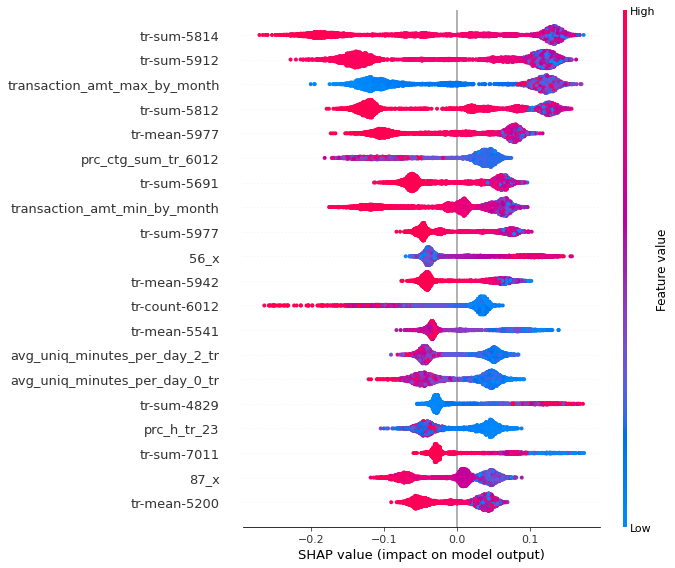

In [40]:
import shap
X_tr = train[cb_classifier.feature_names_]
train_pool = Pool(X_tr, train['target'])
shap_values = cb_classifier.get_feature_importance(train_pool, type='ShapValues')[:, :-1]
shap.summary_plot(shap_values, X_tr)

0.7813366759522773

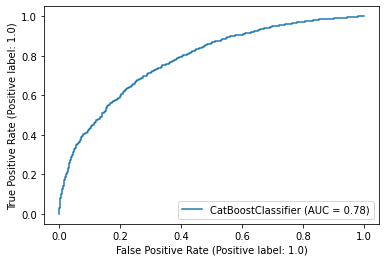

In [41]:
from sklearn.metrics import plot_roc_curve, roc_auc_score

plot_roc_curve(cb_classifier, X_test, y_test)
roc_auc_score(y_test, cb_classifier.predict_proba(X_test)[:,1])

In [ ]:
### Возьмем признаки у котрых вес>0

In [48]:
top_features=list(importances[importances.fscore>0]['features'].values)
len(top_features)

885

In [49]:
top_features

['tr-sum-5912',
 'tr-sum-5814',
 'transaction_amt_max_by_month',
 'tr-sum-5812',
 'tr-mean-5977',
 'prc_ctg_sum_tr_6012',
 'transaction_amt_min_by_month',
 'avg_uniq_minutes_per_day_0_tr',
 'tr-count-6012',
 'tr-sum-5977',
 'prc_h_tr_23',
 '56_x',
 'tr-sum-7011',
 'tr-count-5499',
 'prc_ctg_cnt_cl_251',
 'tr-sum-5691',
 'tr-sum-4829',
 'tr-mean-5541',
 'avg_uniq_minutes_per_day_1_tr',
 'tr-mean-5200',
 'avg_uniq_minutes_per_day_2_tr',
 'tr-mean-5942',
 'prc_h_tr_1',
 'prc_h_tr_10',
 'tr-mean-7011',
 '87_x',
 'prc_h_tr_2',
 'prc_ctg_sum_tr_5921',
 'tr-sum-5200',
 'tr-mean-4829',
 '86_x',
 'tr-mean-5999',
 'tr-count-5533',
 '5211_avg_date_diff_tr',
 '50_x',
 'cl-count-251',
 'tr-mean-5912',
 '5942_avg_date_diff_tr',
 'tr-sum-5942',
 'tr-mean-5661',
 'prc_ctg_cnt_cl_211',
 '7_x',
 'avg_uniq_minutes_per_day_3_tr',
 'tr-count-7011',
 'tr-sum-5661',
 '5814_avg_date_diff_tr',
 '81_x',
 '26_y',
 'tr-mean-8011',
 'tr-sum-7523',
 'tr-mean-5411',
 'tr-sum-4900',
 '68_x',
 'tr-mean-5211',
 '83_x',

In [50]:
top_features=['bank','target','rtk']+top_features
full_dataset=full_dataset[top_features]

In [51]:
train,valid=train_test_split(full_dataset,test_size=0.3,random_state=5)

X_train=train.drop(['target','bank','rtk'],axis=1)
y_train=train['target']
print(X_train.shape,y_train.shape)

X_valid=valid.drop(['target','bank','rtk'],axis=1)
y_valid=valid['target']
print(X_valid.shape,y_valid.shape)

(5956, 885) (5956,)
(2553, 885) (2553,)


In [52]:
train_data = Pool(X_train,y_train,has_header=True)
eval_data = Pool(X_valid,y_valid, has_header=True)

In [53]:
%%time

cb_classifier = CatBoostClassifier(iterations=2000, eval_metric='AUC',random_state=42)
cb_classifier.fit(train_data,eval_set=eval_data, metric_period=50, verbose=50, early_stopping_rounds=100)

Learning rate set to 0.036423
0:	test: 0.6631463	best: 0.6631463 (0)	total: 23.4ms	remaining: 46.8s


50:	test: 0.7755823	best: 0.7755823 (50)	total: 1.03s	remaining: 39.5s
100:	test: 0.7781088	best: 0.7781540 (96)	total: 2.09s	remaining: 39.4s
150:	test: 0.7804455	best: 0.7804455 (150)	total: 3.19s	remaining: 39.1s
200:	test: 0.7814467	best: 0.7815092 (192)	total: 4.24s	remaining: 38s
250:	test: 0.7815363	best: 0.7817917 (243)	total: 5.32s	remaining: 37.1s
300:	test: 0.7809691	best: 0.7817917 (243)	total: 6.4s	remaining: 36.1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7817916659
bestIteration = 243

Shrink model to first 244 iterations.
CPU times: user 5min 6s, sys: 20.3 s, total: 5min 26s
Wall time: 7.53 s


In [54]:
print(f"roc_auc_score: {roc_auc_score(y_train, cb_classifier.predict_proba(X_train)[:, 1])}")
recall = recall_score(y_train,cb_classifier.predict(X_train))
print('recall: ', recall)
precision = precision_score(y_train,cb_classifier.predict(X_train))
print('precision: ', precision)
accuracy = accuracy_score(y_train,cb_classifier.predict(X_train))
print('accuracy: ', accuracy)
f1 = f1_score(y_train,cb_classifier.predict(X_train))
print('f1 score: ', f1)
cm = confusion_matrix(y_train,cb_classifier.predict(X_train))
cm[0][0],cm[1][1]=cm[1][1],cm[0][0]
print('матрица ошибок: \n',cm)

roc_auc_score: 0.9188598387006499
recall:  0.9644915840442703
precision:  0.848650841955772
accuracy:  0.8488918737407656
f1 score:  0.9028707101230304
матрица ошибок: 
 [[4183  746]
 [ 154  873]]


In [55]:
print(f"roc_auc_score: {roc_auc_score(y_valid, cb_classifier.predict_proba(X_valid)[:, 1])}")
recall = recall_score(y_valid,cb_classifier.predict(X_valid))
print('recall: ', recall)
precision = precision_score(y_valid,cb_classifier.predict(X_valid))
print('precision: ', precision)
accuracy = accuracy_score(y_valid,cb_classifier.predict(X_valid))
print('accuracy: ', accuracy)
f1 = f1_score(y_valid,cb_classifier.predict(X_valid))
print('f1 score: ', f1)
cm = confusion_matrix(y_valid,cb_classifier.predict(X_valid))
cm[0][0],cm[1][1]=cm[1][1],cm[0][0]
print('матрица ошибок: \n',cm)

roc_auc_score: 0.7817916658505976
recall:  0.9227820372398685
precision:  0.7786506469500925
accuracy:  0.7571484528006267
f1 score:  0.844611528822055
матрица ошибок: 
 [[1685  479]
 [ 141  248]]


In [36]:
df=pd.read_csv('course/vtb/education/sample_submission.csv')

In [162]:
df[:5]

,bank,higher_education_proba
0,85ef628894e34ad6869778a9a5d15ba5,0.5
1,5ec7a78c6efd4d6291e371a6f30ed5c0,0.5
2,d0f5d1884ad74e3e9aae7e49f2e1b77b,0.5
3,c3c0f24dda94413ab98036f6d9018d3d,0.5
4,6a137054df2a42218a518479317e5b1e,0.5


In [40]:
len(df),len(pd.unique(df.bank))

(4000, 4000)

In [37]:
df_full = df.merge(train_matching,how='left',on='bank')\
               .merge(bankclient_embed, how='left', left_on='bank', right_index=True)\
               .merge(clickstream_embed, how='left', left_on='rtk', right_index=True)\
               .merge(tr_dow, how='left', left_on='bank', right_index=True)\
               .merge(tr_h, how='left', left_on='bank', right_index=True)\
               .merge(transactions_agg, how='left', left_on='bank', right_index=True)\
               .merge(transactions_minutes, how='left', left_on='bank', right_index=True)\
               .merge(transactions_calc, how='left', left_on='bank', right_index=True)\
               .merge(foreign_currency, how='left', left_on='bank', right_index=True)\
               .merge(cl_dow, how='left', left_on='rtk', right_index=True)\
               .merge(cl_h, how='left', left_on='rtk', right_index=True)\
               .merge(clickstream_minutes, how='left', left_on='rtk', right_index=True)\
               .merge(clickstream_calc, how='left', left_on='bank', right_index=True)\
               .merge(clickstream_unq_device, how='left', left_on='rtk', right_index=True)\
               .merge(tr_ctg, how='left', left_on='bank', right_index=True)\
               .merge(cl_ctg, how='left', left_on='rtk', right_index=True)\
               .fillna(0)
df_full=df_full.drop_duplicates()

In [161]:
len(df_full),len(pd.unique(df_full.bank))

(4000, 4000)

In [58]:
top_features.extend(['higher_education_proba'])
top_features.remove('target')
df_full=df_full[top_features]

In [59]:
df_full[:3]

,bank,rtk,tr-sum-5912,tr-sum-5814,transaction_amt_max_by_month,tr-sum-5812,tr-mean-5977,prc_ctg_sum_tr_6012,transaction_amt_min_by_month,avg_uniq_minutes_per_day_0_tr,...,tr-mean-8699,prc_ctg_sum_tr_3750,tr-mean-3501,prc_ctg_sum_tr_5932,cl-count-1493,prc_ctg_cnt_cl_1161,tr-sum-4119,tr-mean-5962,tr-mean-3008,higher_education_proba
0,85ef628894e34ad6869778a9a5d15ba5,dace85ed24ba49ac907c8cab1981e826,-7008.400162,-12117.837635,11648.836858,-4889.290840,-1214.987558,0.050262,-22712.982900,3.382353,...,0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.5
1,5ec7a78c6efd4d6291e371a6f30ed5c0,0,-18983.330309,-12700.126985,13583.477089,-42514.719045,-346.826100,0.097963,-27627.809492,3.375000,...,0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.5
2,d0f5d1884ad74e3e9aae7e49f2e1b77b,0,-8028.189780,-118805.590327,3736.243817,-261332.461004,-2816.327305,0.038021,-52704.946250,2.568182,...,0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.5


In [38]:
df_full_x=df_full.drop(['higher_education_proba','bank','rtk'], axis=1)

In [39]:
df['predict_proba']=cb_classifier.predict_proba(df_full_x)[:, 1]

In [40]:
df=df.drop(['higher_education_proba'], axis=1)
df=df.rename(columns={'predict_proba':'higher_education_proba'})

In [41]:
df.to_csv('course/vtb/education/sample_submission_dv_v3.csv',index=False)

In [52]:
del transactions, clickstream, bankclient_embed, clickstream_embed, full_dataset,transactions_agg,tr_h,\
    tr_dow,cl_h,cl_dow,df_full,df_full_x,transactions_minutes,clickstream_minutes,transactions_calc